~~So, to be totally honest. I have no good reason to do this. I just want to practice **web-scraping**. So I thought I'd scrape the DND wiki to see if I can get the spells from the wiki and just see if we can compare what spells can be shared across classes.~~

So this did start as just a web-scraper but... why stop there? This can be for web-scraping **and** for NLP! So:
1. Can we scrape some info together about the spells that we have in DND.
2. Can we use NLP to find out some sentiment analysis, see if we can build up a classifier.

*We are going to ignore sub-classes and any feats which lets you pull from other spell lists as the list is already extensive and painful as it is*

# 0. Imports and Prerequisites
Let's import what we need to use and set up some key parameters for us to make our quality of life run a bit better

In [122]:
random_code = 42
# Used so we can recreate our results.

In [ ]:
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from collections import defaultdict
import csv
from sklearn.model_selection import train_test_split

In [2]:
# Commented out, download. Run as appropriate.
"""import nltk
nltk.download()"""

'import nltk\nnltk.download()'

In [67]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.tokenize import RegexpTokenizer

In [4]:
exclude = ["discord"]  # Any words we just want to avoid
url = 'https://dnd5e.wikidot.com/'  # Site to scrape

In [5]:
r = requests.get(url)
# Parsing the HTML
soup = BeautifulSoup(r.content, 'html.parser')

# 1. Scraping
We'll start with just picking up on this website and finding what we want.
## 1.1 Top Level Website
The URL above takes us to the front webpage, so we'll see what we can gleam from this.

In [6]:
s = soup.find('div', class_='entry-content')
content = soup.find_all('p')

temp_dict = {}  # We're going to store all the links in a dictionary.
for idx, line in enumerate(content):
    data = line.find_all('a')
    if len(data) > 0: # Ignore all empty lines
        sub_dict = {}  # Our dictionary will be made of sub-dictionaries, just handy for storing the info
        dict_title = None
        for entry in data:
            # This is where we'll exclude our stuff and extract our information
            if not any(excluded in entry.text.lower() for excluded in exclude):
                dict_title = entry.get('href').split(':')[0].split('/')[1]
                sub_dict[entry.text] = entry.get('href')
        
        if dict_title is not None:
            if dict_title in list(temp_dict.keys()):
                temp_dict[dict_title].update(sub_dict)
            else:
                temp_dict[dict_title] = sub_dict

## 1.2 Spells Scraping
Now I want to actually build a list of the spells. 

In [7]:
spell_group = {}
spell_page = {}
spells_dict = temp_dict['spells']
for spells in spells_dict.keys():
    link = url + spells_dict[spells]
    r = requests.get(link)
    # Parsing the HTML
    soup = BeautifulSoup(r.content, 'html.parser')
    s = soup.find('div', class_='entry-content')
    content = soup.find_all('td')
    # Initialise some key points that we'll use to record our for-loop
    spell_info = {}
    spell_name = None
    spell_contents = []
    for idx, line in enumerate(content): # Loop through each line of the table.
        if idx%6 == 0:
            if idx != 0:  # If this is the first entry, we'll initialise the dictionary
                spell_info[spell_name] = spell_contents
            spell_name = line.text
            spell_contents = []
            entry = line.find_all('a') # Now this is used for us to get the links for our new page!
            if len(entry) > 0:
                spell_page[spell_name] = entry[0].get('href')
        else:
            spell_contents.append(line.text)
    spell_group[spells] = spell_info

In [8]:
class_spell_group = {key: value for key, value in spell_group.items() if "Spell" in key}  # This will only group spells by class now.

# 2. Analysis
Now let's see what fun info we can get from this!
## 2.1 Number of Spells
First, let's see how many spells are shared by different classes.

Artificer Spells - Number of Spells: 102
Bard Spells - Number of Spells: 168
Cleric Spells - Number of Spells: 129
Druid Spells - Number of Spells: 175
Paladin Spells - Number of Spells: 53
Ranger Spells - Number of Spells: 75
Sorcerer Spells - Number of Spells: 265
Warlock Spells - Number of Spells: 170
Wizard Spells - Number of Spells: 408


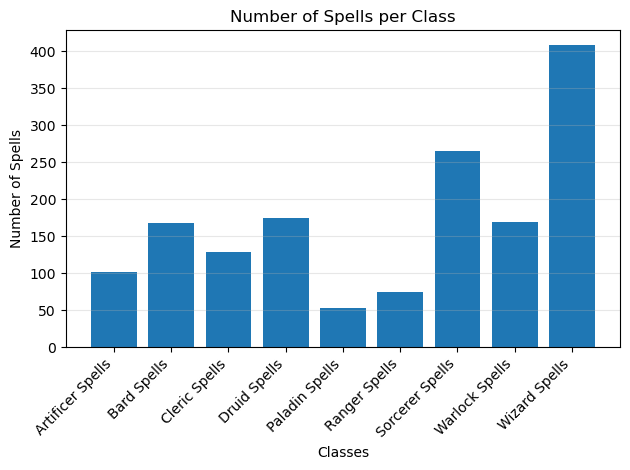

In [9]:
n_spells = []
for classes in class_spell_group:
    n =  len(class_spell_group[classes])
    n_spells.append(n)
    print(classes, "- Number of Spells:", n)

plt.grid(alpha=0.3, axis='y')
plt.bar(class_spell_group.keys(), n_spells)
plt.xlabel("Classes")
plt.ylabel("Number of Spells")
plt.title("Number of Spells per Class")
plt.xticks(rotation=45, ha="right") 
plt.tight_layout() 
plt.show()

In [10]:
spell_to_classes = defaultdict(list)
class_to_spells = defaultdict(list)

for classes, spells in class_spell_group.items():
    for spell in spells:
        spell_to_classes[spell].append(classes)

spells_by_class = {spell: classes for spell, classes in spell_to_classes.items()}
spells_in_multiple_classes = {spell: classes for spell, classes in spell_to_classes.items() if len(classes) > 1}

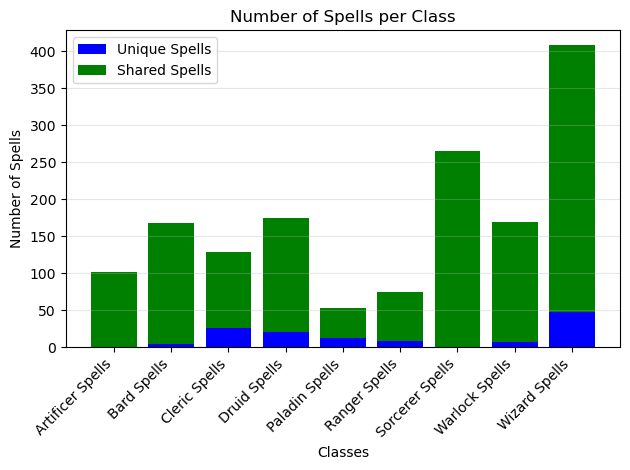

In [11]:
shared_spell_counts = defaultdict(int)

for spell, classes in spells_in_multiple_classes.items():
    for class_name in classes:
        shared_spell_counts[class_name] += 1

classes = list(shared_spell_counts.keys())
shared_counts = list(shared_spell_counts.values())

classes, shared_counts = zip(*sorted(zip(classes, shared_counts)))

total_counts = [len(class_spell_group[class_name]) for class_name in class_spell_group.keys()]
shared_counts = [shared_spell_counts.get(class_name, 0) for class_name in class_spell_group.keys()]
unique_counts = [total - shared for total, shared in zip(total_counts, shared_counts)]

plt.grid(alpha=0.3, axis='y')
plt.bar(class_spell_group.keys(), unique_counts, color='blue', label='Unique Spells')
plt.bar(class_spell_group.keys(), shared_counts, bottom=unique_counts, color='green', label='Shared Spells')
plt.xlabel("Classes")
plt.ylabel("Number of Spells")
plt.title("Number of Spells per Class")
plt.xticks(rotation=45, ha="right")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Oh and for any DND buffs. I'm counting "Cantrips" as spells. I'm not messing about with the whole *"Well they're not **Technically** spells"*, they are and I won't hear otherwise.

In [12]:
for n_classes in range(len(class_spell_group.keys()),1,-1):    
    shared_spells = {spell: classes for spell, classes in spells_in_multiple_classes.items() if len(classes) == n_classes}

    print(f"\nNumber of spells shared amongst {n_classes} classes: {len(shared_spells)}")
    print(f"Spell(s) shared amongst ({n_classes} classes):")
    for spell, classes in shared_spells.items():
        print(f"{spell}: {', '.join(classes)}")


Number of spells shared amongst 9 classes: 0
Spell(s) shared amongst (9 classes):

Number of spells shared amongst 8 classes: 2
Spell(s) shared amongst (8 classes):
Detect Magic: Artificer Spells, Bard Spells, Cleric Spells, Druid Spells, Paladin Spells, Ranger Spells, Sorcerer Spells, Wizard Spells
Dispel Magic: Artificer Spells, Bard Spells, Cleric Spells, Druid Spells, Paladin Spells, Sorcerer Spells, Warlock Spells, Wizard Spells

Number of spells shared amongst 7 classes: 1
Spell(s) shared amongst (7 classes):
Enhance Ability: Artificer Spells, Bard Spells, Cleric Spells, Druid Spells, Ranger Spells, Sorcerer Spells, Wizard Spells

Number of spells shared amongst 6 classes: 8
Spell(s) shared amongst (6 classes):
Mending: Artificer Spells, Bard Spells, Cleric Spells, Druid Spells, Sorcerer Spells, Wizard Spells
Thunderclap: Artificer Spells, Bard Spells, Druid Spells, Sorcerer Spells, Warlock Spells, Wizard Spells
Cure Wounds: Artificer Spells, Bard Spells, Cleric Spells, Druid Sp

## 2.2 Natural Language Processing (NLP)
Okay, so the initial conception of this (*We'll see how this stays as I continue to do this analysis*) is that each of the DND Wiki spell page provides a description of what the spell does. Ultimately, these spells can will provide a lot of information to the reader about what it does.

The original idea was that I would capture these into the following classifications:
1. Damage Dealer (e.g, acid splash does 1d6 damage)
2. Ability Modifier (e.g., guidance provides 1d4 to a skill check)
3. Healing (e.g., healing word does 1d4 hp)
4. Other (e.g., prestidigitation)

But then I realised I would have to label these myself and that just isn't very fun.

**BUT** then I realised, there is already a key inbuilt classification:
1. Conjuration
2. Necromancy
3. Evocation
*So forth so forth*

They have been labelled for me already. Look, this is just practice where I'm apply some skills!
### 2.2.1 Preprocessing 
Let's tidy up the data and put it in a tidy format for us to utilise

In [13]:
spells_descriptions = {}
spell_classifications = {}
for idx, spells in enumerate(spell_page.keys()):
    link = url + spell_page[spells]
    r = requests.get(link)
    # Parsing the HTML
    soup = BeautifulSoup(r.content, 'html.parser')
    s = soup.find('div', class_='entry-content')
    content = soup.find_all('p')
    spell_classifications[spells] = content[1].text
    spells_descriptions[spells] = content[3].text
    """if idx == 5:  # This will run forever, and if there are at least 400 spells, with about a half a second per spell to run this for loop, you have like 4 minutes of waiting.
        break"""

In [103]:
classification_categories = ["abjuration", "conjuration", "divination", "enchantment", "evocation", "illusion", "necromancy", "transmutation"]
other_stop=['•','...in','...the','...you\'ve','–','—','-','⋆','...','C.','c','|','...The','...The','...When','...A','C','+','1','2','3','4','5','6','7','8','9','10', '2016',  'speak','also', 'seen','[5].',  'using', 'get',  'instead',  "that's",  '......','may', 'e', '...it', 'puts', '...over', '[✯]','happens', "they're",'hwo',  '...a', 'called',  '50s','c;', '20',  'per', 'however,','it,', 'yet', 'one', 'bs,', 'ms,', 'sr.',  '...taking',  'may', '...of', 'course,', 'get', 'likely', 'no,']
enhanced_stopwords = stopwords.words('english') + other_stop

spell_classes = [None] * len(classification_categories)

tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
for idx, spell in enumerate(spell_classifications):
    # Get classification
    classification_words = [word.lower() for word in tokenizer.tokenize(spell_classifications[spell])]
    useful_classification_words = [word for word in classification_words if word not in enhanced_stopwords and word in classification_categories][0]
    # Get description
    description_words = [word.lower() for word in tokenizer.tokenize(spells_descriptions[spell])]
    useful_description_words = [word for word in description_words if word not in enhanced_stopwords]
    description_dict = tuple([(word, True) for word in useful_description_words])
    if spell_classes[classification_categories.index(useful_classification_words)] is None:
        spell_classes[classification_categories.index(useful_classification_words)] = [(dict(description_dict),useful_classification_words)]
    else:
        spell_classes[classification_categories.index(useful_classification_words)].append((dict(description_dict),useful_classification_words))

In [133]:
spell_classes[:5]

[[({'touch': True,
    'willing': True,
    'creature': True,
    'spell': True,
    'ends': True,
    'target': True,
    'roll': True,
    'add': True,
    'number': True,
    'rolled': True,
    'saving': True,
    'throw': True,
    'choice': True,
    'die': True},
   'abjuration'),
  ({'spell': True,
    'captures': True,
    'incoming': True,
    'energy': True,
    'lessening': True,
    'effect': True,
    'storing': True,
    'next': True,
    'melee': True,
    'attack': True,
    'resistance': True,
    'triggering': True,
    'damage': True,
    'type': True,
    'start': True,
    'turn': True,
    'first': True,
    'time': True,
    'hit': True,
    'target': True,
    'takes': True,
    'extra': True,
    'ends': True},
   'abjuration'),
  ({'set': True,
    'alarm': True,
    'unwanted': True,
    'intrusion': True,
    'choose': True,
    'door': True,
    'window': True,
    'area': True,
    'within': True,
    'range': True,
    'larger': True,
    'foot': True,
 

In [137]:
full_set = []
for idx, classification in enumerate(spell_classes):
    print(f"{classification_categories[idx]} Spells: ", len(classification))
    full_set += classification
train_set, test_set = train_test_split(full_set, test_size = 0.85, random_state = random_code)

abjuration Spells:  60
conjuration Spells:  109
divination Spells:  40
enchantment Spells:  61
evocation Spells:  115
illusion Spells:  36
necromancy Spells:  45
transmutation Spells:  114


### 2.2.2 Classifier
Now let's build the classifier.

In [138]:
classifier = NaiveBayesClassifier.train(train_set)
classifier.show_most_informative_features(15)

Most Informative Features
                     see = True           enchan : transm =      9.8 : 1.0
                    make = True           enchan : transm =      6.8 : 1.0
                   spell = None           conjur : transm =      6.0 : 1.0
                   touch = True           transm : conjur =      6.0 : 1.0
                  undead = True           necrom : evocat =      5.5 : 1.0
                  wisdom = True           enchan : transm =      5.2 : 1.0
                  saving = True           enchan : abjura =      5.0 : 1.0
                   throw = True           enchan : abjura =      5.0 : 1.0
              statistics = True           necrom : conjur =      5.0 : 1.0
                    must = True           enchan : transm =      5.0 : 1.0
                     see = None           transm : enchan =      4.9 : 1.0
                    form = True           illusi : evocat =      4.8 : 1.0
               advantage = True           divina : conjur =      4.7 : 1.0

In [139]:
accuracy = nltk.classify.util.accuracy(classifier, test_set)
print(accuracy * 100)

33.2657200811359


Predicted: enchantment 

{'conjuration': 0.00017112298229673633, 'transmutation': 2.710240844904082e-07, 'abjuration': 4.300045826626962e-05, 'evocation': 0.030888484561067815, 'divination': 0.00039363140753846746, 'enchantment': 0.6546123692284037, 'illusion': 0.0012803154415140727, 'necromancy': 0.31261080489682874}


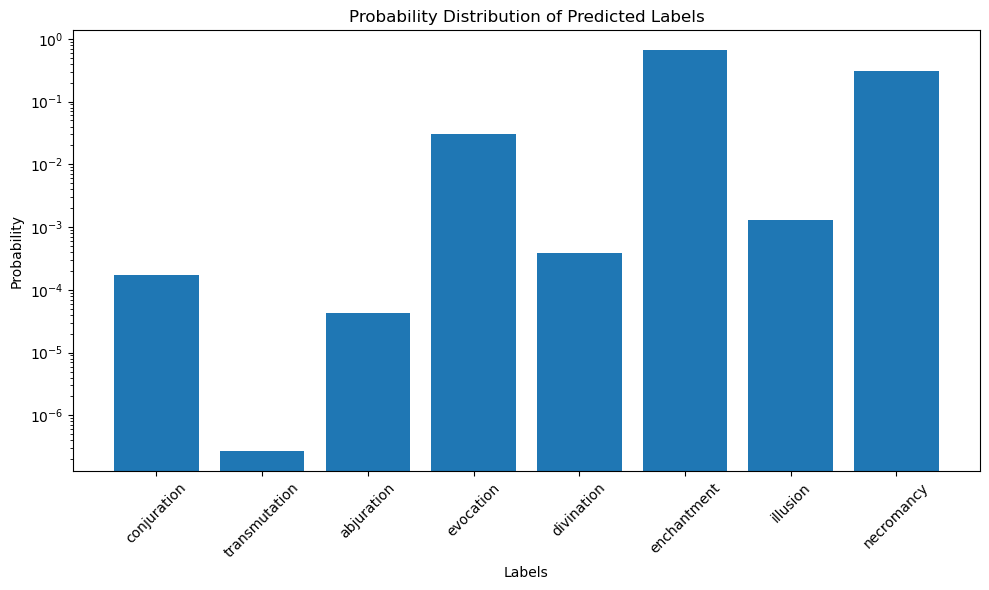

In [140]:
fake_spell = "Create a ball of energy, and hurl it at a creature in sight. On a failed wisdom save, it must take 3d6 psychic damage."
words = tokenizer.tokenize(fake_spell)
useful_words = [word for word in words if word not in enhanced_stopwords]
my_dict = dict([(word, True) for word in useful_words])
prediction = classifier.classify(my_dict)
prob_pred = classifier.prob_classify(my_dict)
print("Predicted:", prediction, "\n")

labels = prob_pred.samples()
probs = [prob_pred.prob(label) for label in labels]

prob_by_label = dict(zip(labels,probs))
print(prob_by_label)

plt.figure(figsize=(10, 6))
plt.bar(labels, probs ,log=True)
plt.xlabel('Labels')
plt.ylabel('Probability')
plt.title('Probability Distribution of Predicted Labels')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3.0 Write to CSV
## 3.1 Write spells by Class
Let's write the spells into a CSV, sorted by each class.

In [141]:
# Additional padding to ensure classes with less spells don't 'clip' the rest of the csv
new_class_spell_group = {
    key: list(values) if isinstance(values, dict) else values
    for key, values in class_spell_group.items()
}

max_length = max(len(values) for values in new_class_spell_group.values())
new_class_spell_group = {
    key: values + [""] * (max_length - len(values))
    for key, values in new_class_spell_group.items()
}

with open("DND_Class_Spells.csv", "w", newline="") as f:
    # Use the keys of the dictionary as the column headers
    w = csv.DictWriter(f, fieldnames=new_class_spell_group.keys())
    w.writeheader()
    
    # Use zip to align rows across all columns
    rows = zip(*new_class_spell_group.values())
    for row in rows:
        # Create a dictionary for each row by zipping keys and values
        w.writerow(dict(zip(new_class_spell_group.keys(), row)))